# Reference Mapping Using cell embedding by pretrained scGPT model

In this tutorial, we demonstrate how to use the scGPT model to embed cells and map them to referenced embeddings. Then the meta labels of the reference cells, such as cell type or disease conditions, can be propagated to the query cells. Particularly, we use the `scGPT_human` model to provide embedings out of the box. In this zero-shot settings, no further training is needed. All the workflow can be completed pretty fast and we observed considerable accuracy.

The pancreas dataset is used in this example. Please download it from https://drive.google.com/drive/folders/1s9XjcSiPC-FYV3VeHrEa7SeZetrthQVV?usp=sharing.

We provide two mode of reference mapping in the following:

1. **Using a customized reference dataset with provided annotations**. Mapping unkown cells in a query set to this reference dataset. This illustrated the use case for users who already have annotations for similar samples and want to quickly transfer the annotation to the newly collected samples.

2. **Using our previously collected over 33 million cells from CellXGene as reference**. Mapping unkown cells in a query set to this reference atlas. This illustrates a generic use case for users who want to map their own data to a large reference atlas. For example, this can be a fast first step to understand the cell composition of a newly collected samples.

According to your use case, you may only need **apply one of the two modes**.

**Note**: please note that the reference mapping is a new experimental feature.


In [ ]:
import sys
from pathlib import Path

import numpy as np
import pandas as pd
from scipy.stats import mode
import scanpy as sc
import sklearn
import warnings

sys.path.insert(0, "../")
import scgpt as scg

# extra dependency for similarity search
try:
    import faiss

    faiss_imported = True
except ImportError:
    faiss_imported = False
    print(
        "faiss not installed! We highly recommend installing it for fast similarity search."
    )
    print("To install it, see https://github.com/facebookresearch/faiss/wiki/Installing-Faiss")

warnings.filterwarnings("ignore", category=ResourceWarning)

## Referrence mapping using a customized reference dataset

In [2]:
model_dir = Path("../save/scGPT_human")
adata = sc.read_h5ad("../data/annotation_pancreas/demo_train.h5ad")
cell_type_key = "Celltype"
gene_col = "index"

scGPT - INFO - match 2999/3000 genes in vocabulary of size 60697.


Embedding cells: 100%|██████████| 166/166 [00:13<00:00, 12.35it/s]


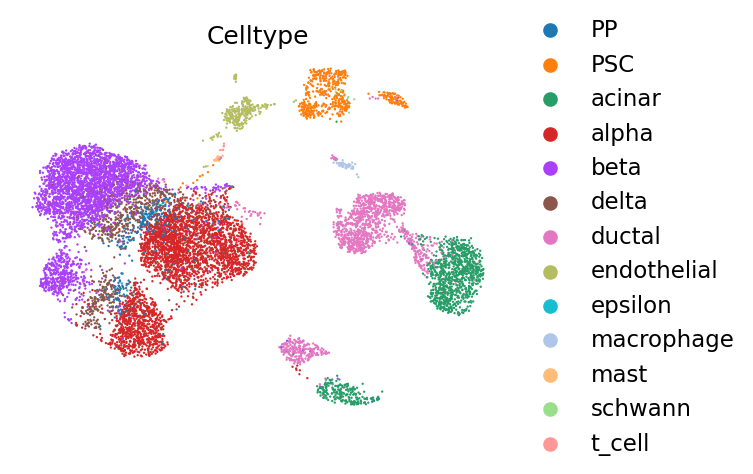

In [3]:
ref_embed_adata = scg.tasks.embed_data(
    adata,
    model_dir,
    cell_type_key=cell_type_key,
    gene_col=gene_col,
    batch_size=64,
    return_new_adata=True,
)

# # running on cpu
# ref_embed_adata = scg.tasks.embed_data(
#     adata,
#     model_dir,
#     cell_type_key=cell_type_key,
#     gene_col=gene_col,
#     batch_size=64,
#     device="cpu",
#     use_fast_transformer=False,
#     return_new_adata=True,
# )

# Optional step to visualize the reference dataset using the embeddings
sc.pp.neighbors(ref_embed_adata, use_rep="X")
sc.tl.umap(ref_embed_adata)
sc.pl.umap(ref_embed_adata, color=cell_type_key, frameon=False, wspace=0.4)

In [4]:
test_adata = sc.read_h5ad("../data/annotation_pancreas/demo_test.h5ad")
test_embed_adata = scg.tasks.embed_data(
    test_adata,
    model_dir,
    cell_type_key=cell_type_key,
    gene_col=gene_col,
    batch_size=64,
    return_new_adata=True,
)

# # running on cpu
# test_embed_adata = scg.tasks.embed_data(
#     test_adata,
#     model_dir,
#     cell_type_key=cell_type_key,
#     gene_col=gene_col,
#     batch_size=64,
#     device="cpu",
#     use_fast_transformer=False,
#     return_new_adata=True,
# )

# # optional step to visualize the dataset
# sc.pp.neighbors(test_embed_adata, use_rep="X")
# sc.tl.umap(test_embed_adata)
# sc.pl.umap(test_embed_adata, color=cell_type_key, frameon=False, wspace=0.4)

scGPT - INFO - match 2999/3000 genes in vocabulary of size 60697.


Embedding cells: 100%|██████████| 66/66 [00:08<00:00,  7.76it/s]


In [5]:
# Those functions are only used when faiss is not installed
def l2_sim(a, b):
    sims = -np.linalg.norm(a - b, axis=1)
    return sims

def get_similar_vectors(vector, ref, top_k=10):
        # sims = cos_sim(vector, ref)
        sims = l2_sim(vector, ref)
        
        top_k_idx = np.argsort(sims)[::-1][:top_k]
        return top_k_idx, sims[top_k_idx]

In [6]:
ref_cell_embeddings = ref_embed_adata.X
test_emebd = test_embed_adata.X

k = 10  # number of neighbors

if faiss_imported:
    # Declaring index, using most of the default parameters from
    index = faiss.IndexFlatL2(ref_cell_embeddings.shape[1])
    index.add(ref_cell_embeddings)

    # Query dataset, k - number of closest elements (returns 2 numpy arrays)
    distances, labels = index.search(test_emebd, k)

idx_list=[i for i in range(test_emebd.shape[0])]
preds = []
for k in idx_list:
    if faiss_imported:
        idx = labels[k]
    else:
        idx, sim = get_similar_vectors(test_emebd[k][np.newaxis, ...], ref_cell_embeddings, k)
    pred = mode(ref_embed_adata.obs[cell_type_key][idx], axis=0)
    preds.append(pred[0][0])
gt = test_adata.obs[cell_type_key].to_numpy()

sklearn.metrics.accuracy_score(gt, preds)

0.7880512091038406

In [7]:
# # optionally, the built index can be saved/loaded for future use
# faiss.write_index(index, "index.faiss")
# index = faiss.read_index("index.faiss")

## Reference mapping using the CellXGene atlas

We have previously built the index for all the cells in normal or cancer samples, over 33 million cells in total. You can find the code to build the index at [build_atlas_index_faiss.py](build_atlas_index_faiss.py).
We applied careful tuning to eventually well balance between the accuracy and efficiency. Now the actual building process takes less than 3 minutes and we choose to use only 16 bytes to store the vector per cell, which leads to 808 MB for the whole index of all the millions of cells. Please download the faiss index folder from https://drive.google.com/drive/folders/1q14U50SNg5LMjlZ9KH-n-YsGRi8zkCbe?usp=sharing.

Faiss is required to use the index. Please install it by following the instructions at https://github.com/facebookresearch/faiss/wiki/Installing-Faiss

In [8]:
from build_atlas_index_faiss import load_index, vote

In [9]:
use_gpu = faiss.get_num_gpus() > 0
index, meta_labels = load_index(
    index_dir="path_to_faiss_index_folder",
    use_config_file=False,
    use_gpu=use_gpu,
)
print(f"Loaded index with {index.ntotal} cells")


Loading index and meta from /scratch/hdd001/home/haotian/projects/cellxemb/all ...
Index loaded, num_embeddings: 40835767
Set nprobe from 128 to 128 for 16384 clusters
Loaded index with 40835767 cells


The search runs super fast, especially on GPU. Here the similarity search for 4,000 query cells within the whole reference of millions should take around 7 second on CPU and 0.1 second on GPU.

In [10]:
%%time
k = 50
# test with the first 100 cells
distances, idx = index.search(test_emebd, k)

CPU times: user 252 ms, sys: 493 ms, total: 745 ms
Wall time: 133 ms


Here, we propagate the previously saved cell type labels, `meta_label`, from CellXGene annotations by majority voting.

In [11]:
predict_labels = meta_labels[idx]
# from scipy.stats import mode
from tqdm import tqdm

voting = []
for preds in tqdm(predict_labels):
    voting.append(vote(preds, return_prob=False)[0])
voting = np.array(voting)

100%|██████████| 4218/4218 [00:00<00:00, 20353.06it/s]


In [18]:
print(gt[:10])   # Original labels in the query dataset, used for evaluation
print(voting[:10])  # Propagated CellXGene labels

['beta' 'beta' 'beta' 'beta' 'PSC' 'beta' 'beta' 'beta' 'ductal' 'alpha']
['neuroendocrine cell' 'classical monocyte' 'neuroendocrine cell'
 'neuroendocrine cell' 'mural cell' 'classical monocyte' 'stromal cell'
 'myeloid cell' 'malignant cell' 'stromal cell']


Currently, we found the CellXGene labels are scattered in different levels of the cell type hieratchy, with more generic cell types such as stromal cells in great abundance. The difference in the number of cells in each cell type may lead to less useful annotations, even though the similarity search itself may be sufficiently accurate. We are working on a better way to curate the cell type labels in a consistent way. Our current idea is plan to apply hierarchical predictions and provide a spectrum of cell type labels for each cell, from generic to more specific cell types.

You may see the proportion of cell types in the meta labels by running
```python
from build_atlas_index_faiss import compute_category_proportion
compute_category_proportion(meta_labels)
```

Meanwhile, the propagation of major cell types is usually more accurate. An example with endothelial cells is provided as follows. 

In [19]:
# find the endothelial cells
ids_m = np.where(gt == "endothelial")[0]
print(f"Found {len(ids_m)} endothelial cells")
print(f"Predicted cell types: {voting[ids_m]}")
print(f"Annotated cell types: {gt[ids_m]}")

Found 16 endothelial cells
Predicted cell types: ['capillary endothelial cell' 'capillary endothelial cell'
 'endothelial cell of vascular tree' 'endothelial cell' 'endothelial cell'
 'endothelial cell' 'endothelial cell' 'endothelial cell'
 'endothelial cell' 'endothelial cell' 'endothelial cell'
 'endothelial cell' 'endothelial cell of vascular tree' 'endothelial cell'
 'endothelial cell' 'vein endothelial cell']
Annotated cell types: ['endothelial' 'endothelial' 'endothelial' 'endothelial' 'endothelial'
 'endothelial' 'endothelial' 'endothelial' 'endothelial' 'endothelial'
 'endothelial' 'endothelial' 'endothelial' 'endothelial' 'endothelial'
 'endothelial']
